Imports

In [2]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix
import seaborn as sns
from statistics import mean
from sklearn.metrics import accuracy_score, mean_squared_error

Data import

In [15]:
df = pd.read_csv('data/processed/EDA3.csv', usecols=['ID','INTERPRET', 'TITEL', 'Text', 'processed_Text','POSITION','DATUM_VON', 'DATUM_BIS', 'DAUER', 'Jahr', 'Monat', 'ANZ_UNIQUE_WOERTER', 'LAENGE_LAENGSTES_WORT', 'RANK_SCORE', 'Number_of_Stopwords', 'Stopword_Percentage', 'SUBJEKTIVITY', 'POLARITY', 'processed_Title'])
df.rename(columns={'Text':'TEXT', 'processed_Text':'processed_TEXT', 'Jahr': 'JAHR', 'Monat': 'MONAT', 'Number_of_Stopwords':'NUMBER_OF_STOPWORDS', 'Stopword_Percentage':'STOPWORD_PERCENTAGE', 'SUBJEKTIVITY':'SUBJECTIVITY', 'processed_Title':'processed_TITLE'}, inplace=True)

print(df.columns)

Index(['ID', 'INTERPRET', 'TITEL', 'TEXT', 'processed_TEXT', 'POSITION',
       'DATUM_VON', 'DATUM_BIS', 'DAUER', 'JAHR', 'MONAT',
       'ANZ_UNIQUE_WOERTER', 'LAENGE_LAENGSTES_WORT', 'RANK_SCORE',
       'NUMBER_OF_STOPWORDS', 'STOPWORD_PERCENTAGE', 'SUBJECTIVITY',
       'POLARITY', 'processed_TITLE'],
      dtype='object')


In [16]:
new_cols = ['ID','INTERPRET', 'TITEL', 'Text', 'processed_Text','POSITION','DATUM_VON', 'DATUM_BIS', 'DAUER', 'Jahr', 'Monat', 'ANZ_UNIQUE_WOERTER', 'LAENGE_LAENGSTES_WORT', 'Number_of_Stopwords', 'Stopword_Percentage', 'SUBJEKTIVITY', 'POLARITY', 'processed_Title', 'RANK_SCORE']
df=df[new_cols]
#or
df=df.reindex(columns=new_cols)
print(np.shape(df))

KeyError: "['Text', 'processed_Text', 'Jahr', 'Monat', 'Number_of_Stopwords', 'Stopword_Percentage', 'SUBJEKTIVITY', 'processed_Title'] not in index"

In [23]:
# label Anpassen
titel_List = set(df.TITEL.tolist())
for titel in titel_List:
    df.loc[df.TITEL == titel,'RANK_SCORE'] = round(mean(df.loc[df.TITEL == titel,'RANK_SCORE'].tolist()))


Train-Test Split

In [25]:
df_test = df.loc[df['JAHR'] == 2022]
df_train = df.loc[df['JAHR'] < 2022]
X_test = df_test[['JAHR', 'ANZ_UNIQUE_WOERTER', 'NUMBER_OF_STOPWORDS', 'STOPWORD_PERCENTAGE', 'SUBJECTIVITY']]
y_test = df_test['RANK_SCORE']

X_train = df_train[['JAHR', 'ANZ_UNIQUE_WOERTER', 'NUMBER_OF_STOPWORDS', 'STOPWORD_PERCENTAGE', 'SUBJECTIVITY']]
y_train = df_train['RANK_SCORE']
print(np.shape(X_train))
print(np.shape(X_test))

#X_train, X_test, y_train, y_test = train_test_split(df['DAUER'], df.RANK_SCORE, test_size=0.5, stratify=df.RANK_SCORE, random_state=123456)

(22056, 5)
(706, 5)


Modelling

AxesSubplot(0.125,0.11;0.775x0.77)


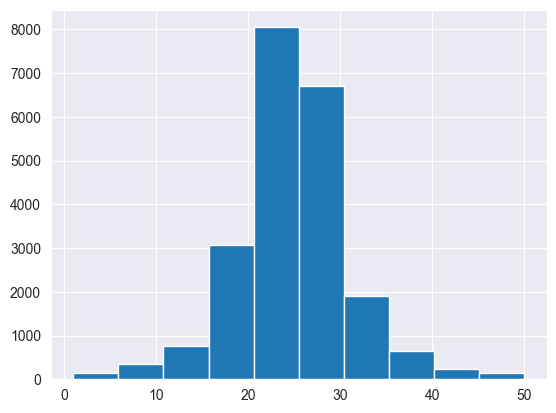

In [27]:
print(y_train.hist())

In [26]:
rf = RandomForestRegressor(n_estimators=100, random_state=123450, oob_score=True)
rf.fit(X_train, y_train)

RandomForestRegressor(oob_score=True, random_state=123450)

In [28]:
score = rf.score(X_train, y_train)
ypred = rf.predict(X_test)
mse = mean_squared_error(y_test, ypred)

print(score)
print("MSE: ", mse)
print("RMSE: ", mse*(1/2.0))
print(np.shape(ypred))
print(np.shape(y_test))
df_ = pd.DataFrame()
df_["y_test"] = y_test
df_["y_pred"] = ypred
print(df_.head())

0.9591032072206342
MSE:  112.49709973300283
RMSE:  56.24854986650141
(706,)
(706,)
     y_test  y_pred
124      26   25.88
125      26   25.88
127      26   25.88
128      26   25.88
129      26   25.88


In [85]:
predicted = rf.predict(X_test)
accuracy = accuracy_score(y_test, predicted)
mse = mean_squared_error(y_test, predicted)

print(f'Out-of-bag score estimate: {rf.oob_score_:.3}')
print(f'Mean accuracy score: {accuracy:.3}')
print(f'Mean Squared Error: {mse:.13}')

ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

In [63]:
cm = pd.DataFrame(confusion_matrix(y_test, predicted), columns=df.RANK_SCORE, index=df.RANK_SCORE)
sns.heatmap(cm, annot=True)

ValueError: Shape of passed values is (50, 50), indices imply (22762, 22762)

In [ ]:
df.RANK_SCORE